### Exploratory Analysis of Phytoplankton's Ecological Niche in Hawaii Ocean Time-series (HOT) Data

In [2]:
# ==================================
#          Preparation
# ==================================
#  Import necessary libraries

import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.express as px

# Local folder that contains all the files with data
data_folder = "/Users/Zhuanz/Documents/VsCode/hot-phytoplankton-analysis/Phytoplankton_Data"

files_to_process = [  # Bottle Extraction data file from different stations of HOT-DOGS
    "(2) ALOHA.nc",
    "(8) HALE-ALOHA.nc",
    "(6) Kaena.nc",
    "(1) Kahe Point.nc",
    "(50) WHOTS.nc",
    "(52) WHOTS.nc",
]

# Empty list as a blanket for later loop to put all the cleaned data in
list_of_dataframes = []

# --- Data cleaning and editing ---
for filename in files_to_process:

    # Join the folder path and file for the absolute path
    file_path = os.path.join(data_folder, filename)

    try:
        # Transfer netCDF to Pandas Dataframe for better editing
        ds = xr.open_dataset(file_path)
        data_dict = {
            "pressure": ds["press"].values,
            "temperature": ds["temp"].values,
            "salinity": ds["bsal"].values,
            "phosphate": ds["phos"].values,
            "nitrate": ds["nit"].values,
            "silicate": ds["sil"].values,
            "chlorophyll": ds["chl"].values,
        }
        df_file = pd.DataFrame(data_dict)

        # Replace all the -9.0 with NaN
        df_file.replace(-9.0, np.nan, inplace=True)

        # Add the cleaned data values to the list
        list_of_dataframes.append(df_file)

    except (
        Exception
    ) as e:  # Double check for any potential mistakes when processing specific file
        print(f"Error: {e} occurs when processing {filename}")

final_df = pd.concat(list_of_dataframes, ignore_index=True)

final_df.info()  # Review of the final data collection

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57037 entries, 0 to 57036
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pressure     57037 non-null  float64
 1   temperature  57037 non-null  float64
 2   salinity     36659 non-null  float64
 3   phosphate    4494 non-null   float64
 4   nitrate      4544 non-null   float64
 5   silicate     4384 non-null   float64
 6   chlorophyll  9887 non-null   float64
dtypes: float64(7)
memory usage: 3.0 MB


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'pressure'),
  Text(0, 1.5, 'temperature'),
  Text(0, 2.5, 'salinity'),
  Text(0, 3.5, 'phosphate'),
  Text(0, 4.5, 'nitrate'),
  Text(0, 5.5, 'silicate'),
  Text(0, 6.5, 'chlorophyll')])

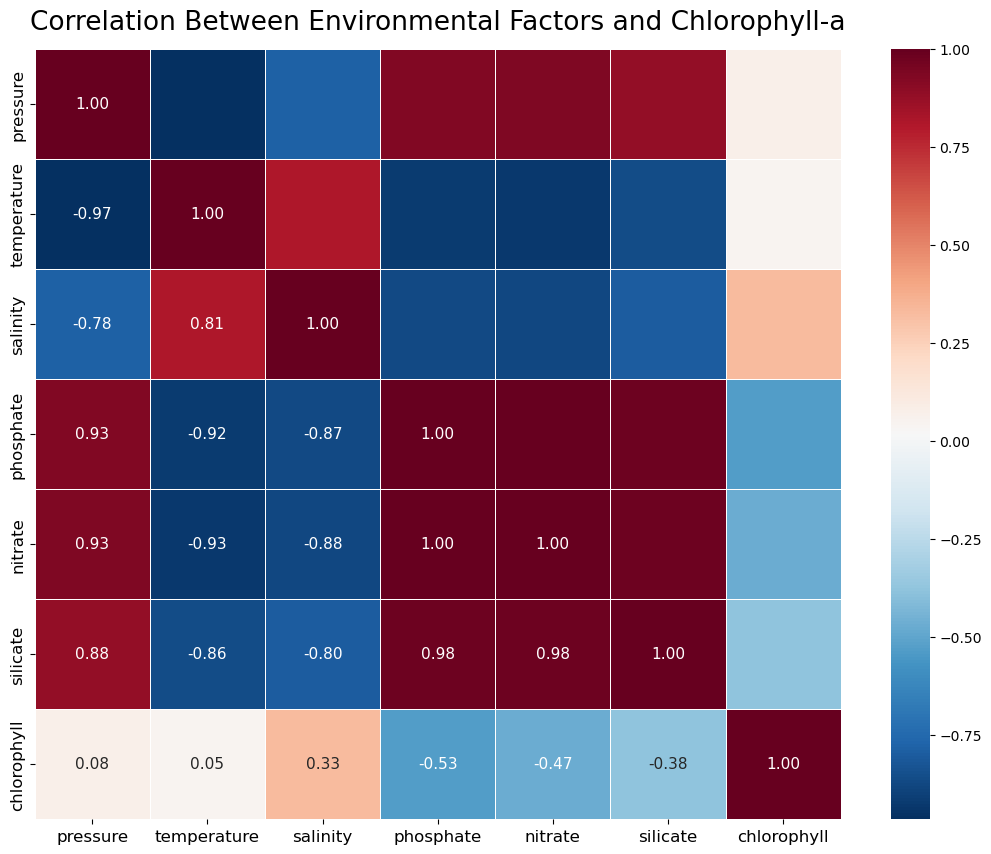

In [3]:
# ===================================
# --- Heatmap: The Grand Overview ---
# ===================================

# Automatically calculate the matrix that includes Pearson correlation coefficient between two values in this dataframe
correlation_matrix = final_df.corr()

# Set up a mask to hide the upper part of the triangle for better demonstration
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
# Change the annotation to hide the number of upper half of the triangle
annot_labels = correlation_matrix.map(lambda x: f"{x:.2f}")
annot_labels[mask] = ""

plt.figure(figsize=(13, 10))

sns.heatmap(
    correlation_matrix,
    annot=annot_labels,
    cmap="RdBu_r",
    fmt="",
    linewidths=0.5,
    annot_kws={"size": 11},
)

plt.title(
    "Correlation Between Environmental Factors and Chlorophyll-a", fontsize=19, y=1.015
)  # Setting up the title format for the graph

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.show()

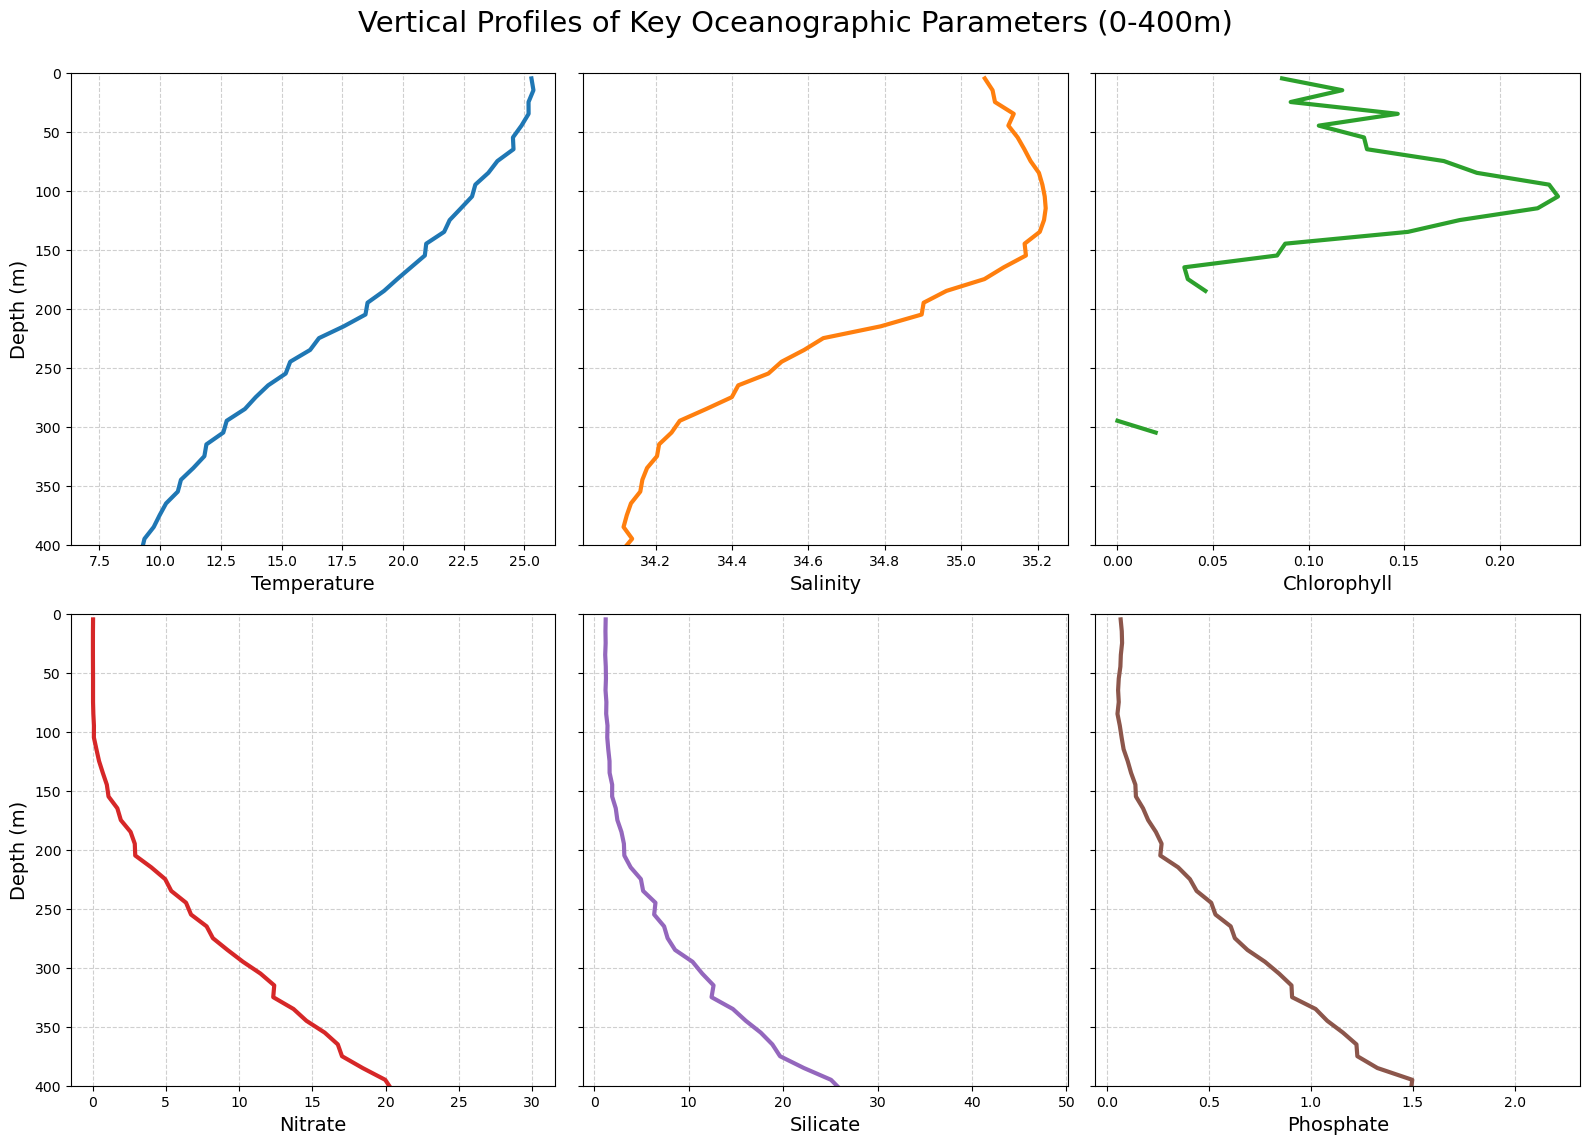

In [4]:
# ======================================================
# --- All-in-one line graph: The scientific context ---
# ======================================================

bins = np.arange(0, 1010, 10)  # Create the edges for the depth bins

final_df["depth_bin"] = pd.cut(
    final_df["pressure"], bins, right=False
)  # Assign a depth interval label to each row in final_df to calculate the mean and the midpoint from each bins
binned_df = final_df.groupby("depth_bin", observed=False).mean()
binned_df["depth_mid"] = [b.mid for b in binned_df.index]

variables_to_plot = [
    "temperature",
    "salinity",
    "chlorophyll",
    "nitrate",
    "silicate",
    "phosphate",
]  # List of all variables and corresponding colors for displaying
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(16, 12), sharey=True
)  # Create subplots
fig.suptitle(
    "Vertical Profiles of Key Oceanographic Parameters (0-400m)", fontsize=21, y=0.95
)

# Loop each variable to draw it on the corresponding subplot
for i, var in enumerate(variables_to_plot):
    ax = axes.flatten()[i]
    ax.plot(binned_df[var], binned_df["depth_mid"], color=colors[i], linewidth=3)
    ax.set_xlabel(var.capitalize(), fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)

# Set up the y-axis label for both rows
axes[0, 0].set_ylabel("Depth (m)", fontsize=14)
axes[1, 0].set_ylabel("Depth (m)", fontsize=14)

axes[0, 0].set_ylim(400, 0)  # Set y-axis range from 0 to 400

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [5]:
# =====================================================================================================================================
# --- Interactive 3D Scatter Plot: Determining the combination effects of temperature, pressure, and nutrient salt such as nitrate ---
# =====================================================================================================================================

df_3d = final_df.dropna(
    # Sort out the four core variables
    subset=["temperature", "nitrate", "pressure", "chlorophyll"]
)

# Further sorting to be less than 400 meters
df_3d = df_3d[df_3d["pressure"] <= 400]

fig = px.scatter_3d(  # Create the 3-d graph with plotly built-in function
    df_3d,
    x="temperature",
    y="nitrate",
    z="pressure",
    color="chlorophyll",
    size="chlorophyll",
    size_max=40,
    color_continuous_scale=px.colors.sequential.Viridis,
    title="3D View: The Ecological Niche for Chlorophyll-a",
    labels={
        "temperature": "Temperature (ºC)",
        "nitrate": "Nitrate (umol/kg)",
        "pressure": "Depth(m)",
        "chlorophyll": "Chlorophyll-a",
    },
)
fig.update_layout(  # Decorative effects
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        zaxis=dict(autorange="reversed"),
        xaxis_showbackground=True,
        yaxis_showbackground=True,
        zaxis_showbackground=True,
    ),
)

fig.show()